In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

df_rewards = pd.read_csv('./out/cumulated_reward.csv', index_col=[0, 1])
df_rewards

reward     reward.1     reward.2     reward.3  \
               createdAt                                                        
MABTree Random 2024-10-02    45.207222    44.395278    48.491111    46.529960   
               2024-10-03    78.744246    77.492431    87.451389    80.665516   
               2024-10-04   115.969127   112.930758   120.076383   119.232391   
               2024-10-05   143.400000   136.671495   150.529143   149.795323   
               2024-10-06   172.153333   166.438858   177.101983   190.732545   
...                                ...          ...          ...          ...   
LinUCB         2024-12-18  3393.359197  3393.359197  3393.359197  3393.359197   
               2024-12-19  3438.827609  3438.827609  3438.827609  3438.827609   
               2024-12-20  3478.117054  3478.117054  3478.117054  3478.117054   
               2024-12-21  3511.423602  3511.423602  3511.423602  3511.423602   
               2024-12-22  3552.908403  3552.908403  3552.908403  3552.908403   

                              reward.4     reward.5     reward.6     reward.7  \
               createdAt                                                        
MABTree Random 2024-10-02    49.971111    45.700714    45.469989    50.296655   
               2024-10-03    79.191451    89.264751    88.001814    83.548878   
               2024-10-04   118.878117   112.984195   126.753481   116.263322   
               2024-10-05   138.714221   152.191558   153.768759   145.833044   
               2024-10-06   167.507078   184.717108   182.145505   175.389711   
...                                ...          ...          ...          ...   
LinUCB         2024-12-18  3393.359197  3393.359197  3393.359197  3393.359197   
               2024-12-19  3438.827609  3438.827609  3438.827609  3438.827609   
               2024-12-20  3478.117054  3478.117054  3478.117054  3478.117054   
               2024-12-21  3511.423602  3511.423602  3511.423602  3511.423602   
               2024-12-22  3552.908403  3552.908403  3552.908403  3552.908403   

                              reward.8     reward.9  
               createdAt                             
MABTree Random 2024-10-02    42.373333    50.940207  
               2024-10-03    71.247500    85.506874  
               2024-10-04   100.526875   124.220137  
               2024-10-05   131.872770   157.521526  
               2024-10-06   159.544873   187.422399  
...                                ...          ...  
LinUCB         2024-12-18  3393.359197  3393.359197  
               2024-12-19  3438.827609  3438.827609  
               2024-12-20  3478.117054  3478.117054  
               2024-12-21  3511.423602  3511.423602  
               2024-12-22  3552.908403  3552.908403  

[574 rows x 10 columns]

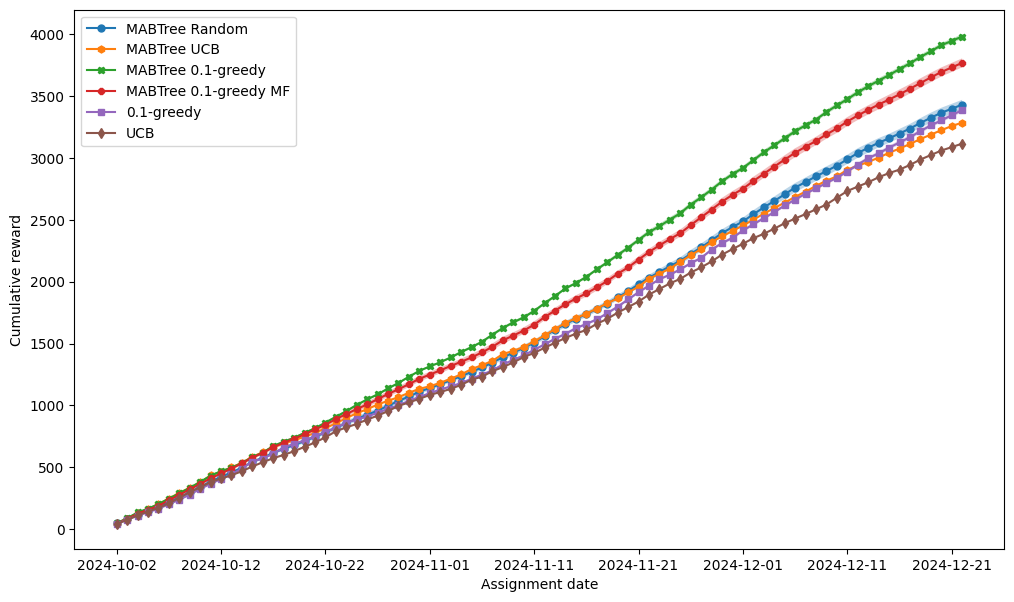

In [2]:
plt.figure(figsize=(12, 7))
plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
for marker, (name, group) in zip(['o', 'h', 'X', '8', 's', 'd'], df_rewards.groupby(level=0, sort=False)):
    m = group.mean(axis=1)
    s = group.std(axis=1)

    CI_min = m - 1.96 * s / group.shape[1] ** 0.5
    CI_max = m + 1.96 * s / group.shape[1] ** 0.5

    plt.plot(group.index.get_level_values(1), m, label=name, marker=marker, markersize=5)
    plt.fill_between(group.index.get_level_values(1), CI_min, CI_max, alpha=0.3)

plt.ylabel('Cumulative reward')
plt.xlabel('Assignment date')
plt.legend()
plt.savefig('./out/cumulative_reward.pdf', format='pdf', bbox_inches='tight')
plt.show()

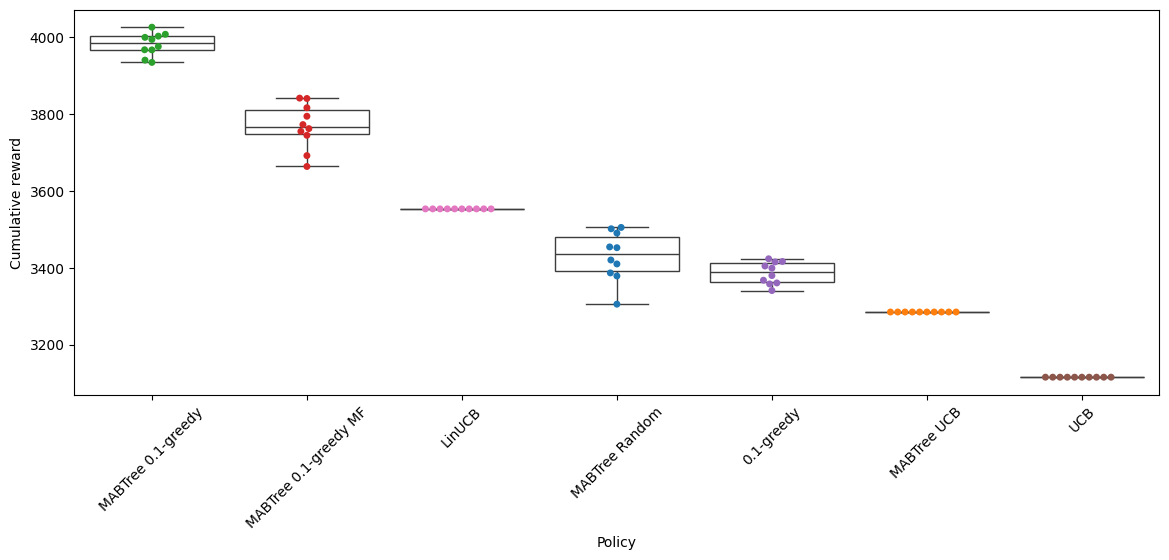

In [3]:
import seaborn as sns
final_cumulative_reward = df_rewards.groupby(level=0, sort=False).last().T
rank = final_cumulative_reward.median().sort_values(ascending=False).index

plt.figure(figsize=(14, 5))
sns.boxplot(data=final_cumulative_reward, color='white', order=rank)
sns.swarmplot(data=final_cumulative_reward)
plt.ylabel('Cumulative reward')
plt.xlabel('Policy')
plt.xticks(rotation=45)
plt.savefig('./out/cumulative_reward_2.pdf', format='pdf')
plt.show()

In [4]:
def highlight_max(s):
    d = s.sort_values(ascending=False)

    style = {
        d.index[0]: 'textbf:--rwrap ;',   # max
        d.index[1]: 'underline:--rwrap ;',  # second max
        d.index[-1]: 'textit:--rwrap ;',  # min
    }

    return [style.get(v, '') for v in s.index]

final_cumulative_reward = final_cumulative_reward.reset_index(drop=True)

final_cumulative_reward \
    .describe().loc[['mean', 'std', 'min', 'max', '50%']].T \
    .style.format('{:.3f}', escape=True).apply(highlight_max, axis=1) \
    .to_latex('./out/cumulative_reward_stats.tex', position='t', position_float='centering', hrules=True, caption='Cumulative reward statistics. The best and second best values of each column are highlighted in bold and underlined, respectively. The worst value is italicized.', label='tab:cumulative_reward_stats')

In [5]:
from scipy import stats
kruskal = stats.kruskal(*[final_cumulative_reward[col] for col in final_cumulative_reward.columns]).pvalue
print(f"{kruskal:.2e}")

1.47e-12


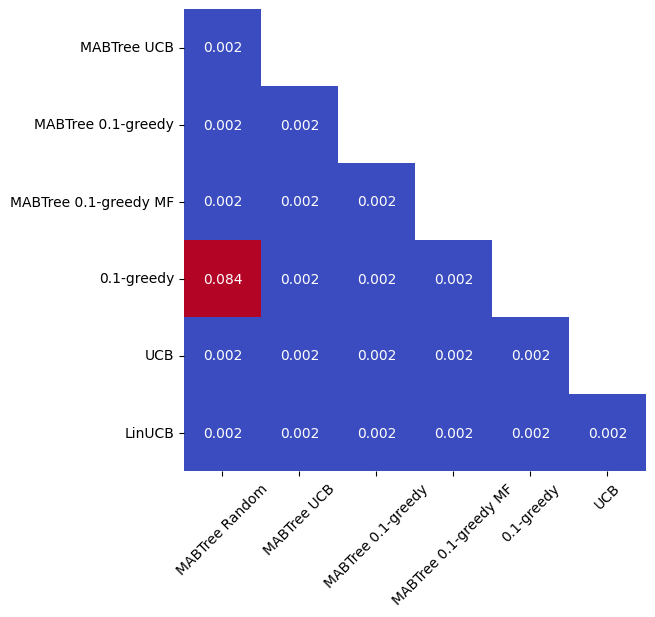

In [6]:
pairwise_wilcoxon = pd.DataFrame(
    columns=final_cumulative_reward.columns,
    index=final_cumulative_reward.columns,
    data=[
        [stats.wilcoxon(final_cumulative_reward[col1], final_cumulative_reward[col2]).pvalue if i > j else np.nan for j, col2 in enumerate(final_cumulative_reward.columns)] 
        for i, col1 in enumerate(final_cumulative_reward.columns)]
).dropna(how='all', axis=0).dropna(how='all', axis=1)

plt.figure(figsize=(6, 6))
sns.heatmap(pairwise_wilcoxon, annot=True, cmap='coolwarm', cbar=False, square=True)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig('./out/cumulative_reward_pairwise_wilcoxon.pdf', format='pdf')
plt.show()

# Coverage

In [7]:
df_coverage = pd.read_csv('./out/coverage.csv', index_col=[0])
df_coverage

,MABTree Random,MABTree UCB,MABTree 0.1-greedy,MABTree 0.1-greedy MF,0.1-greedy,UCB,LinUCB
0,0.808430,0.392817,0.336073,0.720513,0.329083,0.443045,0.486934
1,0.807710,0.392817,0.336881,0.710643,0.331788,0.443045,0.486934
2,0.808360,0.392817,0.336231,0.705866,0.332561,0.443045,0.486934
3,0.809326,0.392817,0.334580,0.734949,0.330629,0.443045,0.486934
4,0.809361,0.392817,0.336407,0.710169,0.332280,0.443045,0.486934
5,0.808289,0.392817,0.335933,0.724974,0.330611,0.443045,0.486934
6,0.807604,0.392817,0.336284,0.722620,0.331788,0.443045,0.486934
7,0.808325,0.392817,0.337057,0.713330,0.330436,0.443045,0.486934
8,0.808395,0.392817,0.336758,0.727538,0.330277,0.443045,0.486934
9,0.807569,0.392817,0.336881,0.708026,0.329031,0.443045,0.486934


In [8]:
final_cumulative_reward

,MABTree Random,MABTree UCB,MABTree 0.1-greedy,MABTree 0.1-greedy MF,0.1-greedy,UCB,LinUCB
0,3453.978365,3284.783678,4006.834584,3839.905995,3423.140860,3115.335922,3552.908403
1,3419.985815,3284.783678,4002.018903,3754.400507,3357.749193,3115.335922,3552.908403
2,3489.956455,3284.783678,4025.325387,3772.034524,3379.564221,3115.335922,3552.908403
3,3501.202660,3284.783678,3966.297226,3840.881397,3340.602419,3115.335922,3552.908403
4,3409.766069,3284.783678,3966.612065,3744.222536,3367.383996,3115.335922,3552.908403
5,3305.175540,3284.783678,3993.365589,3761.605997,3398.769563,3115.335922,3552.908403
6,3504.665456,3284.783678,3975.016301,3691.377416,3360.357527,3115.335922,3552.908403
7,3386.446231,3284.783678,3933.763331,3663.168178,3416.146933,3115.335922,3552.908403
8,3378.512517,3284.783678,3939.626951,3815.863169,3404.340892,3115.335922,3552.908403
9,3452.013438,3284.783678,3998.901367,3793.750197,3414.940782,3115.335922,3552.908403


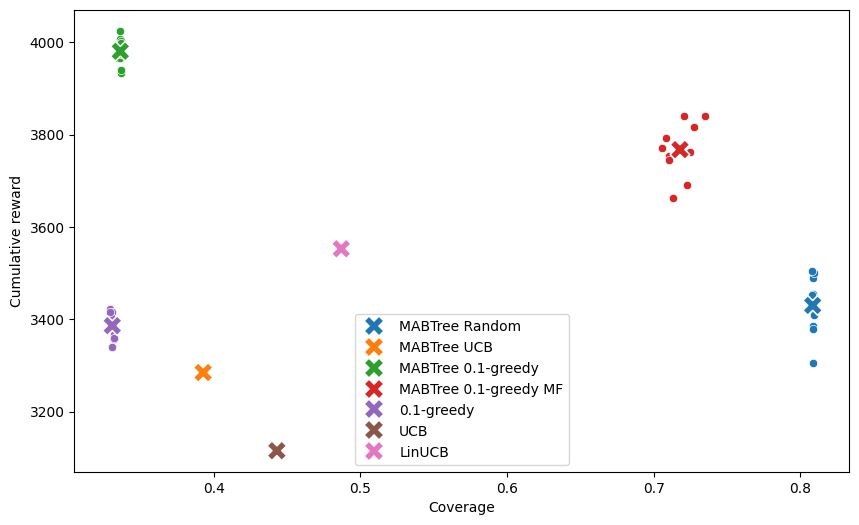

In [9]:
ax = plt.figure(figsize=(10, 6)).gca()
for x, y in zip(df_coverage, final_cumulative_reward):
    sns.scatterplot(x=df_coverage[x], y=final_cumulative_reward[y], ax=ax)
sns.scatterplot(x=df_coverage.mean(axis=0), y=final_cumulative_reward.mean(axis=0), hue=df_coverage.columns, s=200, marker='X', ax=ax)

plt.xlabel('Coverage')
plt.ylabel('Cumulative reward')
plt.legend()
plt.savefig('./out/cumulative_reward_vs_coverage.pdf', format='pdf')
plt.show()